## Actor-Critic 代码实践


In [1]:
import gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import rl_utils

定义策略网络PolicyNet


In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return  F.softmax(self.fc2(x),dim=1)

Actor-Critic 算法额外引入了一个价值网络，接下来的代码定义价值网络ValueNet,输入的是**状态(state)**,输出的是**状态的价值(state value)**

In [3]:
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

接下定义AcotrCritic算法


In [4]:
class ActorCritic:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device) # 价值网络
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr) # 价值网络优化器
        self.gamma = gamma

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(device)

        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones) # 时序差分目标
        td_delta = td_target - self.critic(states) # 时序差分误差
        log_probs = torch.log(self.actor(states).gather(1, actions))
        actor_loss = torch.mean(-log_probs * td_delta.detach())
        critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach())) # 均方误差损失函数
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        actor_loss.backward() # 计算策略网络的梯度
        critic_loss.backward() # 计算价值网络的梯度
        self.actor_optimizer.step() # 更新策略网络参数
        self.critic_optimizer.step() # 更新价值网络参数

In [8]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 2000
hidden_dim = 128
gamma = 0.98
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = "cpu"
env_name = 'CartPole-v0'
env = gym.make(env_name)
env.seed(0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = ActorCritic(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma, device)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

Iteration 9: 100%|████████████████████████████████████████████████████████████████| 200/200 [00:09<00:00, 21.96it/s, episode=2000, return=200.000]


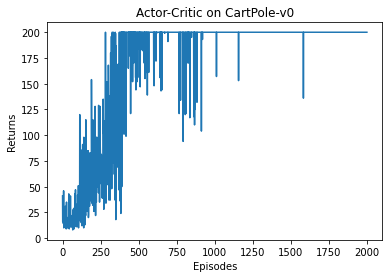

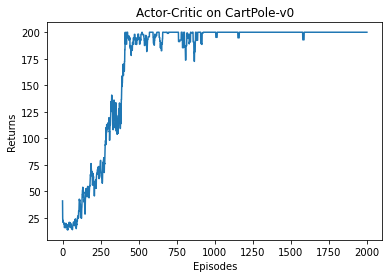

In [9]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list,return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()